In [1]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

2023-06-13 03:35:56.338997: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 03:35:56.373257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 03:35:56.889622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [3]:
# Create log dir
log_dir = "./logging"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [4]:
# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(5e4), callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -634.51
Saving new best model to ./logging/best_model.zip
Num timesteps: 2000
Best mean reward: -634.51 - Last mean reward per episode: -1432.66
Num timesteps: 3000
Best mean reward: -634.51 - Last mean reward per episode: -1220.61
Num timesteps: 4000
Best mean reward: -634.51 - Last mean reward per episode: -1083.63
Num timesteps: 5000
Best mean reward: -634.51 - Last mean reward per episode: -984.03
Num timesteps: 6000
Best mean reward: -634.51 - Last mean reward per episode: -875.14
Num timesteps: 7000
Best mean reward: -634.51 - Last mean reward per episode: -838.96
Num timesteps: 8000
Best mean reward: -634.51 - Last mean reward per episode: -814.22
Num timesteps: 9000
Best mean reward: -634.51 - Last mean reward per episode: -775.84
Num timesteps: 10000
Best mean reward: -634.51 - Last mean reward per episode: -732.84
Num timesteps: 11000
Best mean reward: -634.51 - Last mean reward per episode: -696.75
Nu

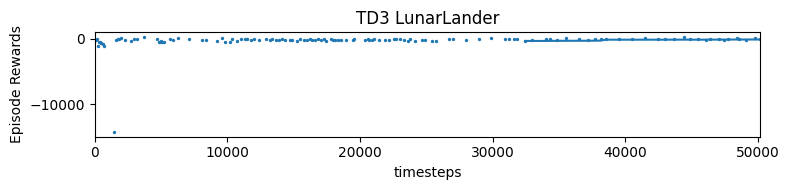

In [8]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(dirs=[log_dir], 
                             num_timesteps=1e5, 
                             x_axis=results_plotter.X_TIMESTEPS, 
                             task_name="TD3 LunarLander"
)

In [6]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

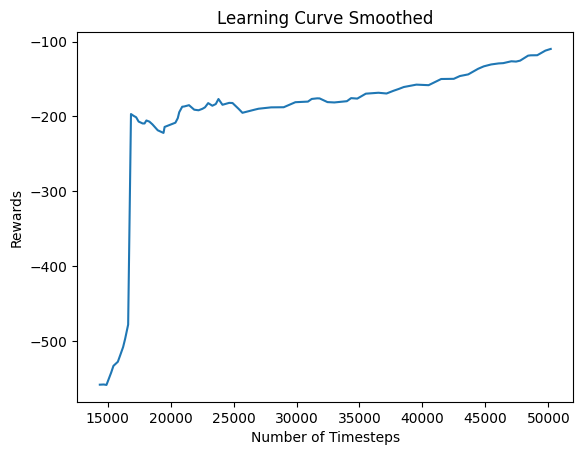

In [7]:
plot_results(log_dir)